In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

#sys.path.append(os.path.abspath(os.path.join('..', 'ARRG')))
from ARRG_macro import *

import importlib

importlib.reload(wasserstein_loss)
importlib.reload(deepsets_classifier)

from wasserstein_loss import WassersteinLoss, WassersteinLoss_POT
from deepsets_classifier import DeepSetsClassifier

from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [44]:
def prepare_data(exp_obs, sim_obs, batch_size=32):
    exp_dataset = TensorDataset(torch.tensor(exp_obs, dtype=torch.float32))
    sim_dataset = TensorDataset(torch.tensor(sim_obs, dtype=torch.float32))

    exp_loader = DataLoader(exp_dataset, batch_size=batch_size, shuffle=True)
    sim_loader = DataLoader(sim_dataset, batch_size=batch_size, shuffle=True)

    return exp_loader, sim_loader
        
def evaluate_model(classifier, test_exp_loader, test_sim_loader):
    classifier.eval()
    test_loss = 0.0
    criterion = nn.BCELoss()
    with torch.no_grad():
        for exp_batch, sim_batch in zip(test_exp_loader, test_sim_loader):
            exp_data, = exp_batch
            sim_data, = sim_batch

            exp_output = classifier(exp_data)
            sim_output = classifier(sim_data)

            exp_labels = torch.ones(exp_output.size(0))
            sim_labels = torch.zeros(sim_output.size(0))

            loss_exp = criterion(exp_output, exp_labels)
            loss_sim = criterion(sim_output, sim_labels)
            loss = (loss_exp + loss_sim) / 2

            test_loss += loss.item() * exp_data.size(0)
    
    print(f'Test Loss: {test_loss/len(test_exp_loader.dataset):.4f}')

In [32]:
class ObservableDataset(Dataset):
	"""
	Converts observable dataset into PyTorch syntax.
	"""
	def __init__(self, data):
		self.data = data

	def __len__(self):
		return self.data.shape[0]

	def __getitem__(self, idx):
		sample = self.data[idx]
		return sample
# Paths to the datasets on perlmutter
exp_hadrons_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_hadrons_a_0.68_b_0.98_sigma_0.335_N_1e6.npy'
#exp_accept_reject_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_accept_reject_z_a_0.68_b_0.98_sigma_0.335_N_1e6.npy'
sim_hadrons_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_hadrons_a_0.72_b_0.88_sigma_0.335_N_1e6.npy'
sim_accept_reject_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_finalTwo_accept_reject_z_a_0.72_b_0.88_sigma_0.335_N_50e3.npy'
sim_fPrel_PATH = '/global/cfs/projectdirs/m3246/hadronization-tune-mlrw-data/pgun_qqbar_finalTwo_fPrel_a_0.72_b_0.88_sigma_0.335_N_50e3.npy'

# Load the arrays
exp_hadrons       = np.load(exp_hadrons_PATH, mmap_mode="r")
sim_hadrons       = np.load(sim_hadrons_PATH, mmap_mode="r")
sim_accept_reject = np.load(sim_accept_reject_PATH, mmap_mode = "r")
sim_fPrel         = np.load(sim_fPrel_PATH, mmap_mode = "r")
# Extract the hadron multiplicity
exp_obs = exp_hadrons # exp_obs = np.array([len(exp_hadrons[i,:][np.abs(exp_hadrons[i,:,0]) > 0.0]) for i in range(exp_hadrons.shape[0])])
sim_obs = sim_hadrons # sim_obs = np.array([len(sim_hadrons[i,:][np.abs(sim_hadrons[i,:,0]) > 0.0]) for i in range(sim_hadrons.shape[0])])
# Print dataset shapes
print('Experimental observable shape:', exp_hadrons.shape)
print('Simulated observable shape:', sim_hadrons.shape)
print('Simulated z shape:', sim_accept_reject.shape)
print('Simulated fPrel shape:', sim_fPrel.shape)

# Restrict to a subset of the full dataset (for memory)
N_events = int(200000)
# Normalize
def unit_normalize(data,axes=(0,1)):
    data_max = data.max(axis=axes)
    data_min = data.min(axis=axes)
    return (data-data_min)/(data_max-data_min)
exp_obs = unit_normalize(exp_obs[0:N_events])
sim_obs = unit_normalize(sim_obs[0:N_events])

# data for calculating event weights
#sim_mult = torch.Tensor([len(sim_hadrons[i,:][np.abs(sim_hadrons[i,:,0]) > 0.0]) for i in range(sim_hadrons.shape[0])])
sim_accept_reject = torch.Tensor(sim_accept_reject[0:N_events].copy()) # z values
sim_fPrel = torch.Tensor(sim_fPrel[0:N_events].copy())
# Convert into torch objects
exp_obs = torch.Tensor(exp_obs.copy())
sim_obs = torch.Tensor(sim_obs.copy())
# Combine and split into training + validation and test sets
train_val_exp_obs, test_exp_obs = train_test_split(exp_obs, test_size=0.2, random_state=42)
train_val_sim_obs, test_sim_obs = train_test_split(sim_obs, test_size=0.2, random_state=42)
# Further split training + validation into separate training and validation sets
train_exp_obs, val_exp_obs = train_test_split(train_val_exp_obs, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2
train_sim_obs, val_sim_obs = train_test_split(train_val_sim_obs, test_size=0.25, random_state=42)

# Check the accepted z-values, if z == 1 reduce it by epsilon (a very nasty bug to find).
# The a-coefficient when computing the likelihood has a term propotional to log(1-z). If 
# z = 1, this term diverges to -inf and completely destroys the backward pass.
epsilon = 1e-5
sim_accept_reject[sim_accept_reject == 1] = 1 - epsilon

# Print dataset shapes
print('Experimental observable shape:', exp_obs.shape)
print('Simulated observable shape:', sim_obs.shape)
print('Simulated z shape:', sim_accept_reject.shape)
print('Simulated fPrel shape:', sim_fPrel.shape)

Experimental observable shape: (1000000, 50, 5)
Simulated observable shape: (1000000, 50, 5)
Simulated z shape: (50000, 105, 101)
Simulated fPrel shape: (50000, 105, 100)
Experimental observable shape: torch.Size([200000, 50, 5])
Simulated observable shape: torch.Size([200000, 50, 5])
Simulated z shape: torch.Size([50000, 105, 101])
Simulated fPrel shape: torch.Size([50000, 105, 100])


In [45]:
# Usage example:
# Assuming 5 features per particle
input_dim = 5
phi_hidden_dim=32
rho_hidden_dim=32
classifier = DeepSetsClassifier(input_dim=input_dim,
                                phi_hidden_dim=phi_hidden_dim, rho_hidden_dim=rho_hidden_dim)
# Prepare data
batch_size=10000
train_exp_loader, train_sim_loader = prepare_data(train_exp_obs, train_sim_obs, batch_size=batch_size)
val_exp_loader, val_sim_loader = prepare_data(val_exp_obs, val_sim_obs, batch_size=batch_size)
test_exp_loader, test_sim_loader = prepare_data(test_exp_obs, test_sim_obs, batch_size=batch_size)

/tmp/ipykernel_1137689/2920987848.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  exp_dataset = TensorDataset(torch.tensor(exp_obs, dtype=torch.float32))
/tmp/ipykernel_1137689/2920987848.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sim_dataset = TensorDataset(torch.tensor(sim_obs, dtype=torch.float32))


In [46]:
# Train the classifier
train=True
classifier = DeepSetsClassifier(input_dim=input_dim,
                                phi_hidden_dim=phi_hidden_dim, rho_hidden_dim=rho_hidden_dim)
if train:
    epochs=5
    lr=0.001
    classifier.train_classifier(train_exp_loader, train_sim_loader, val_exp_loader, val_sim_loader, 
                     num_epochs=epochs, learning_rate=lr)
    torch.save(classifier.state_dict(), "deepsets_classifier.pth")
else:
    classifier.load_state_dict(torch.load('deepsets_classifier.pth'))
    classifier.eval()

Epoch [1/5]
Train Loss: 0.6930, Train Exp Loss: 0.6888, Train Sim Loss: 0.6972
Val Loss: 0.6928, Val Exp Loss: 0.6979, Val Sim Loss: 0.6878

Epoch [2/5]
Train Loss: 0.6926, Train Exp Loss: 0.6910, Train Sim Loss: 0.6943
Val Loss: 0.6924, Val Exp Loss: 0.6853, Val Sim Loss: 0.6994

Epoch [3/5]
Train Loss: 0.6921, Train Exp Loss: 0.6882, Train Sim Loss: 0.6959
Val Loss: 0.6916, Val Exp Loss: 0.6893, Val Sim Loss: 0.6938

Epoch [4/5]
Train Loss: 0.6911, Train Exp Loss: 0.6869, Train Sim Loss: 0.6952
Val Loss: 0.6903, Val Exp Loss: 0.6857, Val Sim Loss: 0.6949

Epoch [5/5]
Train Loss: 0.6894, Train Exp Loss: 0.6855, Train Sim Loss: 0.6934
Val Loss: 0.6882, Val Exp Loss: 0.6860, Val Sim Loss: 0.6904



In [47]:
# Evaluate the model
evaluate_model(classifier, test_exp_loader, test_sim_loader)

Test Loss: 0.6882


In [48]:
classifier(exp_obs[:10])

tensor([0.4861, 0.5077, 0.5125, 0.5187, 0.5045, 0.5010, 0.4892, 0.5039, 0.4975,
        0.4723], grad_fn=<SqueezeBackward0>)

In [49]:
def plot_score_histogram(exp_scores, sim_scores, sim_weights=None, same_bins=False, bins=50):
    """
    Plot a histogram of classifier scores for the given data.
    
    Parameters:
    - exp_scores: numpy array or torch.Tensor of scores from the experimental data
    - sim_scores: numpy array or torch.Tensor of scores from the simulated data
    - sim_weights: numpy array or torch.Tensor of weights for the simulated scores, or None
    - same_bins: bool, whether to use the same bins for both histograms
    - bins: int, number of bins for the histogram
    """
    exp_scores = np.array(exp_scores)
    sim_scores = np.array(sim_scores)
    
    if sim_weights is not None:
        sim_weights = np.array(sim_weights)
    
    if same_bins:
        # Compute the bin edges from the combined range
        min_score = min(exp_scores.min(), sim_scores.min())
        max_score = max(exp_scores.max(), sim_scores.max())
        bin_edges = np.linspace(min_score, max_score, bins + 1)
    else:
        bin_edges = bins
    
    plt.figure(figsize=(10, 6))
    
    # Plot histogram for experimental scores
    plt.hist(exp_scores, bins=bin_edges, density=True, alpha=0.7, label="True")
    
    # Plot histogram for simulated scores with weights if provided
    if sim_weights is not None:
        plt.hist(sim_scores, bins=bin_edges, density=True, weights=sim_weights, alpha=0.7, label="Base")
    else:
        plt.hist(sim_scores, bins=bin_edges, density=True, alpha=0.7, label="Base")
    
    plt.title('Histogram of Classifier Scores (On Test Set)')
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

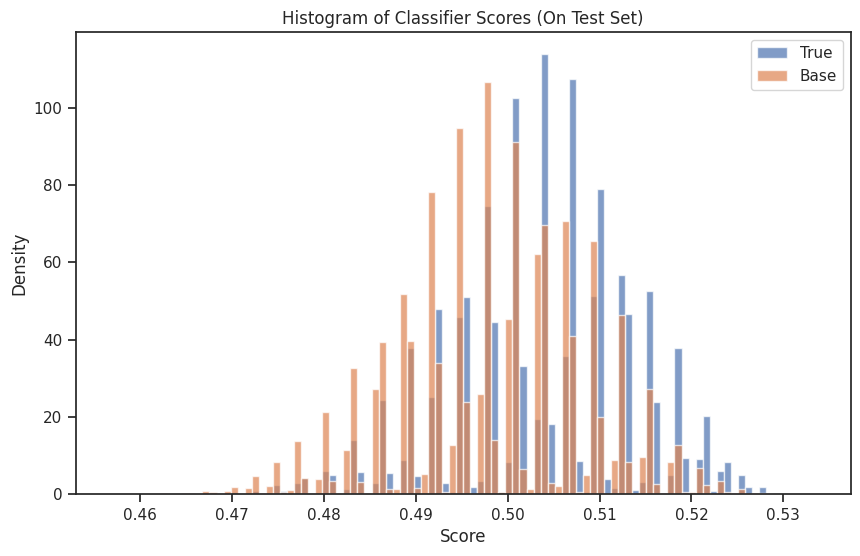

In [50]:
test_exp_scores = classifier(test_exp_obs).detach().numpy()
test_sim_scores = classifier(test_sim_obs).detach().numpy()
plot_score_histogram(test_exp_scores, test_sim_scores, same_bins=True, bins=100)

In [51]:
params_base = torch.tensor([0.72, 0.88])
params_init = torch.tensor([0.7, 0.9])
over_sample_factor = 10.0
# initialize weight module
weight_nexus = LundWeight(params_base, params_init, over_sample_factor = over_sample_factor)

In [52]:
n = 10
print(weight_nexus(sim_accept_reject[:n], sim_fPrel[:n]))

tensor([1.0492, 1.1027, 0.9518, 1.1018, 1.0195, 0.8884, 0.8477, 1.0835, 1.0925,
        0.8541], grad_fn=<MulBackward0>)


In [53]:
class CombinedDataset(Dataset):
    def __init__(self, exp_obs, sim_obs, sim_fPrel, sim_accept_reject):
        self.exp_obs = exp_obs
        self.sim_obs = sim_obs
        self.sim_fPrel = sim_fPrel
        self.sim_accept_reject = sim_accept_reject
        assert len(exp_obs) == len(sim_obs) == len(sim_fPrel) == len(sim_accept_reject), "All inputs must have the same length"

    def __len__(self):
        return len(self.exp_obs)

    def __getitem__(self, idx):
        return {
            'exp_scores': self.exp_obs[idx],
            'sim_scores': self.sim_obs[idx],
            'sim_fPrel': self.sim_fPrel[idx],
            'sim_accept_reject': self.sim_accept_reject[idx],
        }

# Assuming you've already processed your data as described in your code snippet
# and have exp_obs, sim_obs, sim_accept_reject, and sim_mT ready

# Create the dataset
exp_scores = classifier.forward(exp_obs)
sim_scores = classifier.forward(sim_obs)
sar_size = sim_accept_reject.shape[0]
dataset = CombinedDataset(exp_scores[:sar_size], sim_scores[:sar_size], sim_fPrel, sim_accept_reject)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))  # 90% for training
val_size = len(dataset) - train_size  # no worry of overfittitng, remove validation
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 25000  # You can adjust this as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [54]:
params_base = torch.tensor([0.72, 0.88])
params_init = torch.tensor([0.72, 0.881])
# True parameters (0.68, 0.98)
over_sample_factor = 10.0
# initialize weight module
weight_nexus = LundWeight(params_base, params_init, over_sample_factor = over_sample_factor)

class Wasserstein_Tuner:
    def __init__(self, classifier, weight_nexus, learning_rate=0.001):
        self.classifier = classifier
        self.weight_nexus = weight_nexus
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.SGD([self.weight_nexus.params_a, self.weight_nexus.params_b], lr=self.learning_rate)
        self.wasserstein_loss = WassersteinLoss_POT()
        self.param_history = []

    def train(self, train_loader: DataLoader, val_loader: DataLoader, num_epochs: int = 10):
        print("Beginning parameter tuning...")
        print(f"Initial (a, b): ({self.weight_nexus.params_a.item():.4f}, {self.weight_nexus.params_b.item():.4f})")
        for epoch in range(num_epochs):
            # Training loop
            train_loss = 0.0
            self.weight_nexus.eval()
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
                # Unpack the batch
                exp_scores_data = batch['exp_scores']
                sim_scores_data = batch['sim_scores']
                sim_accept_reject_data = batch['sim_accept_reject']
                sim_fPrel_data = batch['sim_fPrel']
                exp_scores_data.detach()
                sim_scores_data.detach()
                sim_accept_reject_data.detach()
                sim_fPrel_data.detach()

                # Zero the gradients
                self.optimizer.zero_grad()
                # Calculate weights
                weights = self.weight_nexus(sim_accept_reject_data, sim_fPrel_data)
                # weights = weights/torch.sum(weights)
                # Calculate Wasserstein distance
                loss = self.wasserstein_loss(exp_scores_data, sim_scores_data, y_weights=weights)
                print("wd =", loss.item())
                
                loss.backward(retain_graph=True)
                # Update parameters
                self.optimizer.step()
                
                weights.detach()
                
                # Record current values of params_a and params_b
                self.param_history.append({
                    'epoch': epoch + 1,
                    'params_a': self.weight_nexus.params_a.item(),
                    'params_b': self.weight_nexus.params_b.item()
                })
                
                # Print current values of params_a and params_b
                print('Gradient of a:', self.weight_nexus.params_a.grad.clone().detach().numpy())
                print('Gradient of b:', self.weight_nexus.params_b.grad.clone().detach().numpy())
                print(f"Current (a, b): ({self.weight_nexus.params_a.item():.6f}, {self.weight_nexus.params_b.item():.6f})")

                train_loss += loss.item()

            # Print training loss for this epoch
            avg_train_loss = train_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4g}")

            # Validation loop
            self.weight_nexus.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    # Unpack the batch
                    exp_scores_data = batch['exp_scores']
                    sim_scores_data = batch['sim_scores']
                    sim_accept_reject_data = batch['sim_accept_reject']
                    sim_fPrel_data = batch['sim_fPrel']

                    # Calculate weights
                    weights = self.weight_nexus(sim_accept_reject_data, sim_fPrel_data)

                    # Calculate Wasserstein distance
                    loss = self.wasserstein_loss(exp_scores_data, sim_scores_data, y_weights=weights)

                    val_loss += loss.item()

            # Print validation loss for this epoch
            avg_val_loss = val_loss / len(val_loader)
            print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4g}")

        return self.weight_nexus

    def Wasserstein_flow(self, flow_loader: DataLoader, a_b_init_grid):
        """
        Generate gradient flow data using the same loss and dataloader as in training.
        """
        # Initialize gradient tensor
        a_b_gradient = torch.zeros(len(a_b_init_grid), 2)
        init_counter = 0

        for a_b_init in tqdm(a_b_init_grid, ncols=100, desc="Wasserstein Flow"):
            # Initialize new weight module with different initial parameters
            self.weight_nexus = LundWeight(params_base, a_b_init, over_sample_factor=over_sample_factor)
            self.weight_nexus.eval()  # Set the model to evaluation mode

            a_b_gradient_i = torch.zeros(2)
            for batch in flow_loader:
                # Unpack the batch
                sim_accept_reject_data = batch['sim_accept_reject']
                sim_fPrel_data = batch['sim_fPrel']
                sim_scores_data = batch['sim_scores']
                exp_scores_data = batch['exp_scores']

                # Zero the gradients
                self.optimizer.zero_grad()

                # Calculate weights
                weights = self.weight_nexus(sim_accept_reject_data, sim_fPrel_data)

                # Calculate Wasserstein distance
                loss = self.wasserstein_loss(exp_scores_data, sim_scores_data, y_weights=weights)

                # Backpropagation to compute gradients
                loss.backward(retain_graph=True)

                # Extract gradients for params_a and params_b
                a_b_gradient_i[0] += self.weight_nexus.params_a.grad.clone().detach()
                a_b_gradient_i[1] += self.weight_nexus.params_b.grad.clone().detach()

            # Average gradients across batches
            a_b_gradient_i /= len(flow_loader)

            # Write to the master gradient tensor
            a_b_gradient[init_counter] = a_b_gradient_i.clone()
            init_counter += 1

        # Convert the gradient tensor to a numpy array
        a_b_gradient = a_b_gradient.numpy()
        return a_b_gradient
    
    def set_learning_rate(self, new_lr: float):
        self.learning_rate = new_lr
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr

    def get_current_parameters(self):
        return {
            'params_a': self.weight_nexus.params_a.item(),
            'params_b': self.weight_nexus.params_b.item()
        }

In [55]:
def a_b_grid(x_range, y_range, n_points):
    """
    Creates a grid of values within a two-dimensional range and returns it in a flattened tensor.

    Parameters:
    x_range (tuple): A tuple of (min, max) for the x-axis range.
    y_range (tuple): A tuple of (min, max) for the y-axis range.
    steps (int): --- The number of steps/points in each dimension.

    Returns:
    torch.Tensor: A flattened tensor containing all the grid points.
    """
    # Create linearly spaced points for each range
    x_points = torch.linspace(x_range[0], x_range[1], n_points)
    y_points = torch.linspace(y_range[0], y_range[1], n_points)

    # Create a meshgrid from the x and y points
    x_grid, y_grid = torch.meshgrid(x_points, y_points, indexing='ij')

    # Flatten the grid and stack the coordinates
    grid_flattened = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)

    return grid_flattened

In [15]:
# Define a grid of initial parameters
a_range  = (0.6, 0.80)
b_range  = (0.85, 1.05)
n_points = 10
a_b_init = a_b_grid(a_range, b_range, n_points)

In [56]:
tuner = Wasserstein_Tuner(classifier, weight_nexus, learning_rate=1)
tuner.train(train_loader, val_loader, num_epochs=1)

Beginning parameter tuning...
Initial (a, b): (0.7200, 0.8810)


Epoch 1/1 [Train]:   0%|          | 0/2 [00:00<?, ?it/s]/global/homes/n/nheller/.conda/envs/herwig_jupyter/lib/python3.12/site-packages/ot/lp/solver_1d.py:41: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  cws = cws.T.contiguous()


wd = 0.005156726576387882


Epoch 1/1 [Train]:  50%|█████     | 1/2 [00:31<00:31, 31.56s/it]

Gradient of a: 0.0003514059
Gradient of b: -0.00025649738
Current (a, b): (0.719649, 0.881256)
wd = 0.005148574709892273


Gradient of a: -0.00028705425
Gradient of b: 0.00041345076
Current (a, b): (0.719936, 0.880843)
Epoch 1/1, Training Loss: 0.005153


Epoch 1/1, Validation Loss: 0.005224


LundWeight()

In [ ]:
tuner.train(train_loader, # Define a grid of initial parameters
a_range  = (0.6, 0.80)
b_range  = (0.85, 1.05)
n_points = 10
a_b_init = a_b_grid(a_range, b_range, n_points), num_epochs=2)
a_b_gradients = tuner.Wasserstein_flow(train_loader, a_b_init)